# CRYPTO ANALYSIS

Using K-Means and Principal Component Analysis (PCA), this method combines financial Python programming with unsupervised learning to cluster cryptocurrencies according to performance over time.

In a CSV file, the data includes returns (price change) information for cryptocurrencies over a number of time periods.


The analysis's steps are divided into the following sections:

* Import the Data
* Prepare the Data
* Find the Best Value for `k` Using the Original Data
* Cluster Cryptocurrencies with K-means Using the Original Data
* Optimize Clusters with Principal Component Analysis
* Find the Best Value for `k` Using the PCA Data
* Cluster the Cryptocurrencies with K-means Using the PCA Data
* Visualize and Compare the Results

In [ ]:
# Import required libraries and dependencies
import pandas as pd

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as px



## Import the Data


In [ ]:
data = pd.read_csv('crypto_market_data.csv')
data.head()

,coin_id,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
0,bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
1,ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
2,tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
3,ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
4,bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384


In [ ]:
data.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


In [ ]:
import hvplot.pandas
# Additional tool to apply the elbow rule
from yellowbrick.cluster import KElbowVisualizer

import holoviews as hv

In [ ]:
data.hvplot.line(
    width=1200,
    height=600,
    rot=90,
    title='Cryptocurrency Market Data: Returns for Several Holding Periods (%)',
    ylabel= 'Return (%)',
    xlabel='Cryptocurrency Name',
    value_label='Return in the Period (%)'
)

:NdOverlay   [Variable]
   :Curve   [index]   (Return in the Period (%))

In [ ]:
print(data.dtypes)


coin_id                          object
price_change_percentage_24h     float64
price_change_percentage_7d      float64
price_change_percentage_14d     float64
price_change_percentage_30d     float64
price_change_percentage_60d     float64
price_change_percentage_200d    float64
price_change_percentage_1y      float64
dtype: object


In [ ]:
print(data.isnull().sum())


coin_id                         0
price_change_percentage_24h     0
price_change_percentage_7d      0
price_change_percentage_14d     0
price_change_percentage_30d     0
price_change_percentage_60d     0
price_change_percentage_200d    0
price_change_percentage_1y      0
dtype: int64


In [ ]:
print(data['coin_id'].dtype)


object


In [ ]:
data['coin_id'] = data['coin_id'].astype('object')


In [ ]:
print(data['coin_id'].unique())


['bitcoin' 'ethereum' 'tether' 'ripple' 'bitcoin-cash' 'binancecoin'
 'chainlink' 'cardano' 'litecoin' 'bitcoin-cash-sv' 'crypto-com-chain'
 'usd-coin' 'eos' 'monero' 'tron' 'tezos' 'okb' 'stellar' 'cosmos' 'cdai'
 'neo' 'wrapped-bitcoin' 'leo-token' 'huobi-token' 'nem' 'binance-usd'
 'iota' 'vechain' 'zcash' 'theta-token' 'dash' 'ethereum-classic'
 'ethlend' 'maker' 'havven' 'omisego' 'celsius-degree-token' 'ontology'
 'ftx-token' 'true-usd' 'digibyte']


---

## Prepare the Data

This section prepares the data before running the K-Means algorithm.

1. Use `StandardScaler` module from scikit-learn to normalize the CSV file data. 



In [ ]:
# Try to convert each column to numeric values and print any columns that fail
for col in data.columns:
    try:
        pd.to_numeric(data[col])
    except ValueError:
        print(f"Could not convert {col} to numeric values")

# Select the columns you want to normalize
normalize = [ 
    'price_change_percentage_24h',
    'price_change_percentage_7d',
    'price_change_percentage_14d',
    'price_change_percentage_30d',
    'price_change_percentage_60d',
    'price_change_percentage_200d',
    'price_change_percentage_1y']

# Create a scaler object and fit it to the data
scaled_data = StandardScaler()
scaled_data.fit(data[normalize])

# Apply the scaler to the data
data[normalize] = scaled_data.transform(data[normalize])

# Print the first few rows of the normalized dataframe to verify that it was scaled correctly
print(data.head())

Could not convert coin_id to numeric values
        coin_id  price_change_percentage_24h  price_change_percentage_7d  \
0       bitcoin                     0.508529                    0.493193   
1      ethereum                     0.185446                    0.934445   
2        tether                     0.021774                   -0.706337   
3        ripple                    -0.040764                   -0.810928   
4  bitcoin-cash                     1.193036                    2.000959   

   price_change_percentage_14d  price_change_percentage_30d  \
0                     0.772200                     0.235460   
1                     0.558692                    -0.054341   
2                    -0.021680                    -0.061030   
3                     0.249458                    -0.050388   
4                     1.760610                     0.545842   

   price_change_percentage_60d  price_change_percentage_200d  \
0                    -0.067495                     -0.35


2. Create a DataFrame that contains the scaled data. The column `coin_id` from the original DataFrame will be set as index.

In [ ]:
# Create a DataFrame with the scaled data
data_scaled = pd.DataFrame(
    data=scaled_data.transform(data[normalize]),
    columns=normalize,
    index=data.index
)

# Concatenate the scaled data with the non-scaled data from the original DataFrame
data_scaled = pd.concat(
    [data_scaled, data[data.columns[-1]]],
    axis=1
)

# Print the first few rows of the scaled dataframe to verify that it was scaled correctly
print(data_scaled.head())



   price_change_percentage_24h  price_change_percentage_7d  \
0                     0.292372                   -0.635852   
1                     0.170991                   -0.565778   
2                     0.109500                   -0.826344   
3                     0.086005                   -0.842954   
4                     0.549539                   -0.396410   

   price_change_percentage_14d  price_change_percentage_30d  \
0                     0.070873                    -0.050353   
1                     0.045069                    -0.061490   
2                    -0.025074                    -0.061747   
3                     0.007695                    -0.061338   
4                     0.190330                    -0.038425   

   price_change_percentage_60d  price_change_percentage_200d  \
0                     0.000569                     -0.551062   
1                    -0.003834                     -0.550504   
2                     0.002183                     -0.55

In [ ]:
# Create a DataFrame with the scaled data
data_scaled = pd.DataFrame(
    data=scaled_data.transform(data[normalize]),
    columns=normalize,
    index=data.index
)

data_scaled["coin_id"] = data.index

data_scaled = data_scaled.set_index("coin_id")

data_scaled.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
0,0.292372,-0.635852,0.070873,-0.050353,0.000569,-0.551062,-0.282281
1,0.170991,-0.565778,0.045069,-0.061490,-0.003834,-0.550504,-0.282238
2,0.109500,-0.826344,-0.025074,-0.061747,0.002183,-0.551514,-0.282305
3,0.086005,-0.842954,0.007695,-0.061338,-0.005964,-0.551300,-0.282316
4,0.549539,-0.396410,0.190330,-0.038425,-0.004213,-0.551397,-0.282296


In [ ]:
# Plot the scaled data
data_scaled.hvplot.line(
    width=1100,
    height=400,
    rot=90,
    title='Cryptocurrency Market Data Scaled: Standarized Returns for Several Holding Periods (%)',
    ylabel= 'Standarized Return (%)',
    xlabel='Cryptocurrency Name',
    value_label='Standarized Return in the Period (%)'
)

:NdOverlay   [Variable]
   :Curve   [coin_id]   (Standarized Return in the Period (%))

In [ ]:
# Check for missing values
print(data_scaled.isna().sum())

# Fill missing values with mean
df = data_scaled.fillna(data_scaled.mean())

# Drop missing values
data_scaled = data_scaled.dropna()

price_change_percentage_24h     0
price_change_percentage_7d      0
price_change_percentage_14d     0
price_change_percentage_30d     0
price_change_percentage_60d     0
price_change_percentage_200d    0
price_change_percentage_1y      0
dtype: int64


---

## Find the Best Value for k Using the Original Data

The best value for 'k' will be determined in this section using the elbow approach.

1. Uses a scale of 1 to 11. 

2. To clearly determine the ideal value for 'k,' we will draw a line chart with all the inertia values calculated with the various values of 'k'.

In [ ]:
# Create a list with the number of k-values to try
# Use a range from 1 to 11
k = range(1,12)
list(k)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
# Create an empy list to store the inertia values
inertia = []

In [ ]:
for i in k:
    model = KMeans(n_clusters=i)
    model.fit(data_scaled)
    inertia.append(model.inertia_)
    
inertia

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when

[7.499447623367811,
 3.8856882702166184,
 2.621255539690543,
 1.8917683853167433,
 1.298823973372038,
 1.0231971202888341,
 0.8576779174959142,
 0.6984328349248756,
 0.5531116561335855,
 0.4693046700399862,
 0.425821016389526]

In [ ]:
# Create a dictionary with the data to plot the Elbow curve
dictionary = {'k':k, 'inertia':inertia}

# Create a DataFrame with the data to plot the Elbow curve
inertia_df = pd.DataFrame(dictionary)

inertia_df

,k,inertia
0,1,7.499448
1,2,3.885688
2,3,2.621256
3,4,1.891768
4,5,1.298824
5,6,1.023197
6,7,0.857678
7,8,0.698433
8,9,0.553112
9,10,0.469305


To find the best value it is helpful to quantify the decrease in inertia with each increment of *k*.

In [ ]:
inertia_df['inertia_fraction_with_respect_to_one_cluster'] = inertia_df['inertia']/inertia_df.iloc[0,1]

inertia_df['inertia_rate_of_decrease'] = inertia_df['inertia_fraction_with_respect_to_one_cluster'] - inertia_df['inertia_fraction_with_respect_to_one_cluster'].shift()
inertia_df

,k,inertia,inertia_fraction_with_respect_to_one_cluster,inertia_rate_of_decrease
0,1,7.499448,1.000000,NaN
1,2,3.885688,0.518130,-0.481870
2,3,2.621256,0.349526,-0.168603
3,4,1.891768,0.252254,-0.097272
4,5,1.298824,0.173189,-0.079065
5,6,1.023197,0.136436,-0.036753
6,7,0.857678,0.114365,-0.022071
7,8,0.698433,0.093131,-0.021234
8,9,0.553112,0.073754,-0.019378
9,10,0.469305,0.062579,-0.011175


Based on the inertia rate of decrease, we can see that with k=4 we decrease 15% of inertia, but after that decrease stagnates. It looks like k=4 can be a good candidate. 

Let's check this visually now.

In [ ]:
original_inertia_plot=inertia_df.hvplot(
    x      = 'k',
    y      = 'inertia',
    title  = 'Standarized Performance Data: Inertia versus Number of Clusters',
    xlabel = 'Number of Clusters (k)',
    ylabel = 'Inertia (units)'
)
original_inertia_plot

:Curve   [k]   (inertia)

The visual verify the previous assesment of k=4 as an optimal number of clusters.

As an additional exersice, we will also apply another metric technique called Calinski Harabarz, which will verify also our results, and can be helpful in cases the visual are not so clear.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when

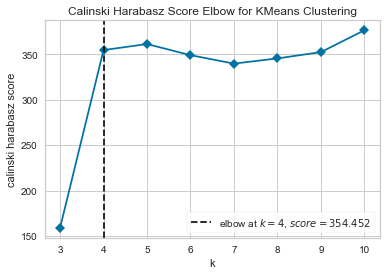

In [ ]:
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Additional tool to select k applying Calinski Harabasz metric
model_used = KMeans()
visualizer = KElbowVisualizer(
    model_used, 
    k=(3,11), 
    metric='calinski_harabasz', 
    timings=False
)

visualizer.fit(data_scaled)        
visualizer.show();



Based on the elbow rule, k=4 is the best choice. This, because:
* With k=4, the inertia is significantly reduced, going from 123 with k=3 to 79 with k=4. Reductions don't get much better after that for more than 16 inertia units.  
* Because the inertia starts to decrease in a nearly linear fashion at k=4, the elbow at k=4 is also noticable graphically.

## Cluster Cryptocurrencies with K-means Using the Original Data

In order to cluster the cryptocurrencies in this section, we will apply the K-Means technique using the best value for "k" found in the previous section (k=4).

1. Use the best value for 'k' to initialise the K-Means model with four clusters. 

2. Using the original (scaled) data, fit the K-Means model.

3. Using the original data, predict the clusters that will group the cryptocurrencies. View the cluster values in the generated array.

4. To save the predicted clusters, add a new column to the DataFrame containing the original data.

5. Make a scatter plot that compares each cryptocurrency's 1-year returns against its 2-week returns.

In [ ]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=4)

In [ ]:
# Fit the K-Means model using the scaled data
model.fit(data_scaled)

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=4)

In [ ]:
# Predict the clusters to group the cryptocurrencies using the scaled data
clusters = model.predict(data_scaled)

# View the resulting array of cluster values.
clusters

array([2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 2, 2, 0, 2, 0, 2])

In [ ]:
# Add a new column to the DataFrame with the predicted clusters
data_scaled['cluster_original'] = clusters

data_scaled.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,cluster_original
coin_id,,,,,,,,
0,0.292372,-0.635852,0.070873,-0.050353,0.000569,-0.551062,-0.282281,2
1,0.170991,-0.565778,0.045069,-0.061490,-0.003834,-0.550504,-0.282238,2
2,0.109500,-0.826344,-0.025074,-0.061747,0.002183,-0.551514,-0.282305,0
3,0.086005,-0.842954,0.007695,-0.061338,-0.005964,-0.551300,-0.282316,0
4,0.549539,-0.396410,0.190330,-0.038425,-0.004213,-0.551397,-0.282296,2


In [ ]:
data_scaled.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,cluster_original
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.101320,-0.714174,-0.022454,-0.059402,0.002012,-0.550234,-0.282076,0.878049
std,0.380363,0.160779,0.122360,0.038908,0.021640,0.002355,0.000821,1.099889
min,-1.770037,-0.981290,-0.290410,-0.112941,-0.018423,-0.551516,-0.282317,0.000000
25%,0.053431,-0.826397,-0.098590,-0.077101,-0.009782,-0.551397,-0.282305,0.000000
50%,0.130435,-0.744456,-0.023565,-0.061747,-0.001392,-0.551060,-0.282259,0.000000
75%,0.225781,-0.635852,0.055326,-0.054923,0.002355,-0.550344,-0.282194,2.000000
max,0.822586,-0.305685,0.328888,0.146258,0.103966,-0.539458,-0.277136,3.000000


In [ ]:
plot_original_clusters = data_scaled.hvplot.scatter(
    x     = "price_change_percentage_14d", 
    y     = "price_change_percentage_1y", 
    by    = 'cluster_original',
    title = "Cryptocurrencies Standarized Returns. K-Mean Clusters with k=4.",
    hover_cols = 'coin_id'
)
plot_original_clusters

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_14d]   (price_change_percentage_1y,coin_id)

---

## Optimize Clusters with Principal Component Analysis

principle component analysis (PCA) will be used in this part to reduce all the features into only three principle components.

1. To reduce to three principal components, create an instance of a PCA model. 

2. Obtain the explained variance and calculate the information content of each primary component.

3. Establish how much of the three primary components' explained variation can be explained.

4. Make a new DataFrame with the PCA information. 

In [ ]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components = 3)

# coming back to the original data
data_scaled_no_clusters = data_scaled.drop(columns='cluster_original')

In [ ]:
# Use the PCA model with `fit_transform` to reduce to three principal components.
market_data_pca = pca.fit_transform(data_scaled_no_clusters)

# View the first five rows of the DataFrame. 
market_data_pca[0:5]

array([[-0.2065276 ,  0.08760698,  0.03045182],
       [-0.08988998,  0.15121733, -0.02204383],
       [ 0.00278277, -0.09900122,  0.05109257],
       [ 0.02417746, -0.09403537,  0.08594275],
       [-0.49641972,  0.31781299,  0.00109605]])

In [ ]:
# Retrieve the explained variance to determine how much information can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.78513862, 0.16140791, 0.04868986])

In [ ]:
# Total explained variance with 3 components
pca.explained_variance_ratio_.sum()

0.9952363898440519

In [ ]:
pca.components_

array([[-9.89397718e-01, -9.38785753e-02, -1.05732608e-01,
        -3.19408852e-02, -8.13273989e-03,  3.27152025e-03,
         1.58769912e-03],
       [-1.35320690e-01,  8.60361048e-01,  4.89450085e-01,
         4.35578676e-02, -2.42009701e-03,  1.46124984e-03,
         7.15381860e-04],
       [-5.13454907e-02, -4.84161477e-01,  8.11432876e-01,
         2.93233109e-01,  1.36106543e-01,  4.11842021e-03,
         6.19566161e-04]])

## Principal components representation:

>1) The first component gives higher importance to the longer term returns (200 days and 1 year)

>2) The second component gives higher importance to the middle term returns (30 days and 60 days)

>3) The third component gives more importance to short term returns (7 days)

In [ ]:
# Creating a new DataFrame with the PCA data
data_pca = pd.DataFrame(market_data_pca, columns=['PC1','PC2','PC3'])

# Copy the crypto names from the original data
data_pca['coin_id'] = data_scaled.index

# Set the coin_id column as index
data_pca = data_pca.set_index('coin_id')

# Display sample data
data_pca.head()

,PC1,PC2,PC3
coin_id,,,
0,-0.206528,0.087607,0.030452
1,-0.089890,0.151217,-0.022044
2,0.002783,-0.099001,0.051093
3,0.024177,-0.094035,0.085943
4,-0.496420,0.317813,0.001096


---

## Find the Best Value for k Using the PCA Data

In this section, using the PCA data and the same procedures we used with the original scaled data, we will apply the elbow approach to determine the best value for 'k'.

In [ ]:
k = list(range(1,12))
k

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
inertia_pca = []

In [ ]:
for i in k:
    model_pca = KMeans(n_clusters = i)
    model_pca.fit(data_pca)
    inertia_pca.append(model_pca.inertia_)

inertia_pca

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when

[7.463723178505133,
 3.85073515385215,
 2.5884195629263673,
 1.8504030547657777,
 1.2362770188218009,
 0.9839077481318391,
 0.835724821075579,
 0.6983813553392578,
 0.5413143790166609,
 0.47013658108773243,
 0.4278307663402296]

In [ ]:
# Create a dictionary with the data to plot the Elbow curve
inertia_pca = {'k':k, 'inertia_pca':inertia_pca}

# Create a DataFrame with the data to plot the Elbow curve
inertia_pca_df = pd.DataFrame(inertia_pca)

inertia_pca_df = inertia_pca_df.set_index('k')
inertia_pca_df


,inertia_pca
k,
1,7.463723
2,3.850735
3,2.588420
4,1.850403
5,1.236277
6,0.983908
7,0.835725
8,0.698381
9,0.541314


In [ ]:
inertia_pca_df['inertia_rate_with_respect_to_one_cluster'] = inertia_pca_df['inertia_pca']/inertia_pca_df.iloc[0,0]


inertia_pca_df['inertia_rate_of_decrease'] = inertia_pca_df['inertia_rate_with_respect_to_one_cluster'] - inertia_pca_df['inertia_rate_with_respect_to_one_cluster'].shift()
inertia_pca_df

,inertia_pca,inertia_rate_with_respect_to_one_cluster,inertia_rate_of_decrease
k,,,
1,7.463723,1.000000,NaN
2,3.850735,0.515927,-0.484073
3,2.588420,0.346800,-0.169127
4,1.850403,0.247920,-0.098880
5,1.236277,0.165638,-0.082281
6,0.983908,0.131825,-0.033813
7,0.835725,0.111972,-0.019854
8,0.698381,0.093570,-0.018401
9,0.541314,0.072526,-0.021044


In [ ]:
inertia_pca_plot = inertia_pca_df['inertia_pca'].hvplot(
    title  = 'Principal Components of the Standarized Performance: Inertia v/s Number of Clusters',
    xlabel = 'Number of Clusters (k)',
    ylabel = 'Inertia (units)'     
)

inertia_pca_plot

:Curve   [k]   (inertia_pca)

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when

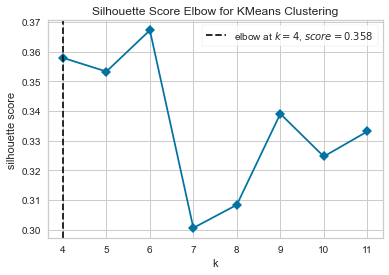

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(
    model, 
    k=(4, 12), 
    metric='silhouette', 
    timings=False
)
visualizer.fit(data_pca)
visualizer.show()

We can see that again the best value for the number of clusters k is 4. It does not differ from the original data analysis. However, what does differ is the Inertia itself at that point, which is 79 with k=4 with the standarized data, and only 50 using 3 PCA. Definetily a significant improvement. Not even with k=6 we got a level of 50 for the inertia with the standarized regular data. 
  
  The reasons to choose again k=4 are similar than the ones to choose k=4 for the scalar original data:
* with k=4 we get a significant inertia reduction from 94 in k=3 to 50 in k=4. After that, reductions do not improve in more than 11 inertia units.  
* Graphically, the elbow on k=4 is also notizable, because after k=4 the inertia start decreasing in a close to linear fashion.
* Finally, the KelbowVisualizer tool corroborates the qualitative prior analysis, with k=4 as the best choice, as can be seen in plot below.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when

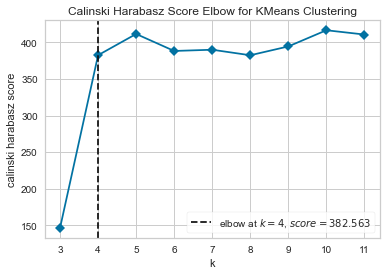

In [ ]:
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Additional tool to select k applying Calinski Harabasz metric
model_2 = KMeans()
visualizer = KElbowVisualizer(
    model_2, 
    k = (3,12), 
    metric = 'calinski_harabasz', 
    timings = False
)

visualizer.fit(data_pca)        
visualizer.show();

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when

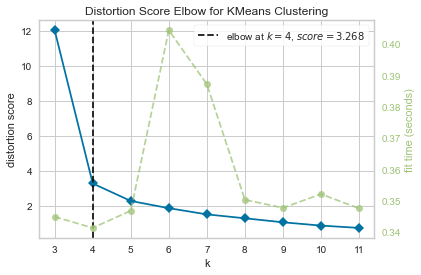

In [ ]:
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Additional tool to select k applying inertia elbow, but k selection provided by the software instead of visually determine it ourselves
model_2 = KMeans()
visualizer = KElbowVisualizer(
    model_2, 
    k=(3,12)
)

visualizer.fit(data_pca)        
visualizer.show();

---

## Cluster Cryptocurrencies with K-means Using the PCA Data

We will cluster the cryptocurrencies according to the major components in this section using the PCA data and the K-Means algorithm using the best value for k found in the previous section.

1. Use the best value for 'k' to initialise the K-Means model with four clusters. 

2. Using the PCA data, fit the K-Means model.

3. Using the PCA data, forecast the clusters that will group the cryptocurrencies. View the cluster values in the generated array.

4. To save the predicted clusters, add a new column to the DataFrame containing the PCA data.


In [ ]:
# Initialize the K-Means model using the best value for k
k = 4
model_pca = KMeans(n_clusters=k, random_state=1)

In [ ]:
# Fit the K-Means model using the PCA data
model_pca.fit(data_pca)

C:\Users\Dhruv Suthar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=4, random_state=1)

In [ ]:
# Predict the clusters to group the cryptocurrencies using the PCA data
cluster = model_pca.predict(data_pca)
cluster[0:5]

array([0, 0, 2, 2, 0])

In [ ]:
# Add a new column to the DataFrame with the predicted clusters
data_pca['cluster_pca'] = cluster

data_pca.head()

,PC1,PC2,PC3,cluster_pca
coin_id,,,,
0,-0.206528,0.087607,0.030452,0
1,-0.089890,0.151217,-0.022044,0
2,0.002783,-0.099001,0.051093,2
3,0.024177,-0.094035,0.085943,2
4,-0.496420,0.317813,0.001096,0


In [ ]:
data_pca.describe()

,PC1,PC2,PC3,cluster_pca
count,4.100000e+01,4.100000e+01,4.100000e+01,41.000000
mean,-5.009543e-17,4.603364e-17,-1.963199e-17,1.414634
std,3.836700e-01,1.739591e-01,9.554410e-02,1.024100
min,-6.982289e-01,-3.010621e-01,-2.240379e-01,0.000000
25%,-1.544512e-01,-1.058596e-01,-5.199680e-02,0.000000
50%,-4.468613e-02,-3.799971e-02,7.791059e-04,2.000000
75%,3.980488e-02,9.251614e-02,5.099329e-02,2.000000
max,1.869136e+00,4.152639e-01,3.866771e-01,3.000000


In [ ]:
# From the original DataFrame, add the `price_change_percentage_1y` and `price_change_percentage_14d columns`.
data_pca['cluster_original']            = data_scaled['cluster_original']
data_pca['price_change_percentage_1y']  = data_scaled['price_change_percentage_1y']
data_pca['price_change_percentage_60d'] = data_scaled['price_change_percentage_60d']
data_pca['price_change_percentage_7d']  = data_scaled['price_change_percentage_7d']
data_pca['price_change_percentage_24h'] = data_scaled['price_change_percentage_24h']

data_pca

,PC1,PC2,PC3,cluster_pca,cluster_original,price_change_percentage_1y,price_change_percentage_60d,price_change_percentage_7d,price_change_percentage_24h
coin_id,,,,,,,,,
0,-0.206528,0.087607,0.030452,0,2,-0.282281,0.000569,-0.635852,0.292372
1,-0.089890,0.151217,-0.022044,0,2,-0.282238,-0.003834,-0.565778,0.170991
2,0.002783,-0.099001,0.051093,2,0,-0.282305,0.002183,-0.826344,0.109500
3,0.024177,-0.094035,0.085943,2,0,-0.282316,-0.005964,-0.842954,0.086005
4,-0.496420,0.317813,0.001096,0,2,-0.282296,-0.004213,-0.396410,0.549539
5,-0.361600,0.183206,-0.039162,0,2,-0.282259,0.018655,-0.503392,0.436392
6,-0.055895,0.415264,-0.098193,0,2,-0.282091,-0.017908,-0.305685,0.105602
7,-0.069204,0.239787,-0.051997,0,2,-0.282202,-0.008384,-0.474694,0.139840
8,-0.044686,0.092516,0.055782,2,0,-0.282314,-0.005822,-0.661086,0.130435


In [ ]:
# We will color the clusters accordingly to the sort in the dataframe

color_pca = list(data_pca['cluster_pca'].drop_duplicates().reset_index()['cluster_pca'])

color_original = list(data_pca['cluster_original'].drop_duplicates().reset_index()['cluster_original'])
print(color_pca)
print(color_original)

[0, 2, 3, 1]
[2, 0, 3, 1]


In [ ]:
k = 4

# colors_pallette = ['green', 'blue', 'red','orange']
colors_pallette = ['orange', 'red', 'blue', 'green']

# Initialization of colors with NaN
colors_pca, colors_original = [np.nan] * k, [np.nan] *k


In [ ]:
c = 0
for i in color_pca:
    colors_pca[i] = colors_pallette[c]
    c += 1
colors_pca

['orange', 'green', 'red', 'blue']

In [ ]:
c = 0
for i in color_original:
    colors_original[i] = colors_pallette[c]
    c += 1
colors_original

['red', 'green', 'orange', 'blue']

## Plotting the Principal Components

In [ ]:
# Plotting the PCAs
color=hv.Cycle(colors_pca)
pca_longer_term_plot=data_pca.hvplot.scatter(
    x  = 'PC1',
    y  = 'PC2',
    by = 'cluster_pca',
    hover_cols='coin_id',
    title  = "Principal Components K-Means Clusters and PC1 versus PC2",
    color  =  color,
    xlabel = 'First Principal Component \n Returns (%) (PC1)',
    ylabel = 'Second Principal Component \n Returns (%) (PC2)',
    width  = 600,
    height = 500
).opts(legend_position='top')

pca_longer_term_plot

:NdOverlay   [cluster_pca]
   :Scatter   [PC1]   (PC2,coin_id)

In [ ]:
# Plotting the PCAs
color = hv.Cycle(colors_pca)
pca_shorter_term_plot=data_pca.hvplot.scatter(
    x  = 'PC2',
    y  = 'PC3',
    by = 'cluster_pca',
    hover_cols='coin_id',
    title  = 'Principal Components K-Means Clusters and PC2 versus PC3',
    xlabel = 'Second Principal Component \n Returns (%) (PC2)',
    ylabel = 'Third  Principal Component \n Returns (%) (PC3)',
    color  = color,
    width  = 600,
    height = 500
).opts(legend_position='top')
pca_shorter_term_plot

:NdOverlay   [cluster_pca]
   :Scatter   [PC2]   (PC3,coin_id)

In [ ]:
# Plotting the PCAs
color = hv.Cycle(colors_pca)
pca_mix_term_plot = data_pca.hvplot.scatter(
    x  = 'PC1',
    y  = 'PC3',
    by = 'cluster_pca',
    hover_cols = 'coin_id',
    title  = "Principal Components K-Means Clusters and PC1 versus PC3",
    color  =  color,
    xlabel = 'First Principal Component \n Returns (%) (PC1)',
    ylabel = 'Second Principal Component \n Returns (%) (PC3)',
    width  = 600,
    height = 500
).opts(legend_position='top')

pca_mix_term_plot

:NdOverlay   [cluster_pca]
   :Scatter   [PC1]   (PC3,coin_id)

In [ ]:
# Three dimentional visualization of clusters with the three principal components
df = data_pca.reset_index()
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3' #, size='gdpPercap', 
                    ,color='cluster_pca'
                    ,hover_data=['coin_id'],
                    title='Principal Components - KMean Clusters'
)
fig.update_layout(scene_zaxis_type="log")
fig.show()

In [ ]:
# Very short term

color = hv.Cycle(colors_original)
very_short_term_scaled_data_plot = data_scaled.hvplot.scatter(
    x  = "price_change_percentage_24h",
    y  = "price_change_percentage_7d",
    by = 'cluster_original',
    hover_cols = 'coin_id',
    title = 'Standarized Returns & K-Means Clusters - Very Short Term Performance',
    color = color,
    xlabel = 'Standarize 24h Return (%)',
    ylabel = 'Standarize 7d Return (%)',
    width  = 600,
    height = 500
).opts(legend_position='top')

very_short_term_scaled_data_plot

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)

In [ ]:
# Short term

color = hv.Cycle(colors_original)
short_term_scaled_data_plot = data_scaled.hvplot.scatter(
    x  = "price_change_percentage_7d",
    y  = "price_change_percentage_14d",
    by = 'cluster_original',
    hover_cols='coin_id',
    title  = 'Standarized Returns & K-Means Clusters - Short Term Performance',
    color  =  color,
    xlabel = 'Standarize 7 Days Return (%)',
    ylabel = 'Standarize 14 Days Return (%)',
    width  = 600,
    height = 500
).opts(legend_position='top')
short_term_scaled_data_plot

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_7d]   (price_change_percentage_14d,coin_id)

In [ ]:
# Middle Term

color = hv.Cycle(colors_original)
middle_term_scaled_data_plot = data_scaled.hvplot.scatter(
    x  = "price_change_percentage_30d",
    y  = "price_change_percentage_60d",
    by = 'cluster_original',
    hover_cols='coin_id',
    title  = 'Standarized Returns & K-Means Clusters - Middle Term Performance',
    color  = color,
    xlabel = 'Standarize 30 Days Return (%)',
    ylabel = 'Standarize 60 Days Return (%)',
    width  = 600,
    height = 500
).opts(legend_position='top')
middle_term_scaled_data_plot

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_30d]   (price_change_percentage_60d,coin_id)

In [ ]:
# Longer term
 
color = hv.Cycle(colors_original)
longer_term_scaled_data_plot = data_scaled.hvplot.scatter(
    x  = "price_change_percentage_200d",
    y  = "price_change_percentage_1y",
    by = 'cluster_original',
    hover_cols='coin_id',
    title  = 'Standarized Returns & K-Means Clusters - Longer Term Performance',
    color  =  color,
    xlabel = 'Standarize 200 Days Return (%)',
    ylabel = 'Standarize 1 Year Return (%)',
    width  = 600,
    height = 500
).opts(legend_position='top')

longer_term_scaled_data_plot

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_200d]   (price_change_percentage_1y,coin_id)

In [ ]:
# Mix Short/Longer terms
 
color = hv.Cycle(colors_original)
mix_short_longer_term_scaled_data_plot = data_scaled.hvplot.scatter(
    y  = "price_change_percentage_14d",
    x  = "price_change_percentage_1y",
    by = 'cluster_original',
    hover_cols = 'coin_id',
    title  = 'Standarized Returns & K-Means Clusters - Mix Term Performance',
    color  =  color,
    ylabel = 'Standarize 14 Days Return (%)',
    xlabel = 'Standarize 1 Year Return (%)',
    width  = 600,
    height = 500
).opts(legend_position='top')

mix_short_longer_term_scaled_data_plot

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_1y]   (price_change_percentage_14d,coin_id)

In [ ]:
# Mix Middle/Longer terms
 
color=hv.Cycle(colors_original)
mix_middle_longer_term_scaled_data_plot=data_scaled.hvplot.scatter(
    y  = "price_change_percentage_60d",
    x  = "price_change_percentage_1y",
    by = 'cluster_original',
    hover_cols = 'coin_id',
    title  = 'Standarized Returns & K-Means Clusters - Mix Term Performance',
    color  =  color,
    ylabel = 'Standarize 60 Days Return (%)',
    xlabel = 'Standarize 1 Year Return (%)',
    width  = 600,
    height = 500
).opts(legend_position='top')

mix_middle_longer_term_scaled_data_plot

:NdOverlay   [cluster_original]
   :Scatter   [price_change_percentage_1y]   (price_change_percentage_60d,coin_id)

---

# K-Mean Clusters for Cryptocurrencies Based on Performance Over Several Holding Periods


By comparing the outcomes obtained with and without the use of optimisation techniques, we visually analyse the cluster analysis results in this part.

1. Compare the original and PCA data with the Elbow Curve you produced to determine the optimal value for "k."

2. Using the original and the PCA data, compare the cryptocurrency clusters.

In [ ]:
# 1. Composite plot to contrast the Elbow curves
original_inertia_plot + inertia_pca_plot

:Layout
   .Curve.I           :Curve   [k]   (inertia)
   .Curve.Inertia_pca :Curve   [k]   (inertia_pca)

In [ ]:

very_short_term_scaled_data_plot + pca_shorter_term_plot

:Layout
   .NdOverlay.I  :NdOverlay   [cluster_original]
      :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)
   .NdOverlay.II :NdOverlay   [cluster_pca]
      :Scatter   [PC2]   (PC3,coin_id)

In [ ]:

mix_middle_longer_term_scaled_data_plot+pca_longer_term_plot

:Layout
   .NdOverlay.I  :NdOverlay   [cluster_original]
      :Scatter   [price_change_percentage_1y]   (price_change_percentage_60d,coin_id)
   .NdOverlay.II :NdOverlay   [cluster_pca]
      :Scatter   [PC1]   (PC2,coin_id)

In [ ]:
# Mix terms performance
mix_short_longer_term_scaled_data_plot + pca_mix_term_plot


:Layout
   .NdOverlay.I  :NdOverlay   [cluster_original]
      :Scatter   [price_change_percentage_1y]   (price_change_percentage_14d,coin_id)
   .NdOverlay.II :NdOverlay   [cluster_pca]
      :Scatter   [PC1]   (PC3,coin_id)

## Impacts of using fewer features to cluster the data using K-Means

### First, at the level of inertia
* Using less amount of features reduces the amount of inertia. This happens because the reduction of dimensionality implies a reduction in the variance of the clustered data. In the analyzed case, we reduced the variance in 10% by using three components, which implied a reduction in the inertia in a similar amount (11% reduction from 287 to 256). This kind of reduction could have involved a reduction in optimal number of clusters. However in this case, it didn't. 
* PCA achieves a higher reduction rate of the initial inertia. That means, the components are more efficient in setting up the data for clustering. In the case of PCA, the reduction was from 256 to 50 units of inertia, which is a reduction in 80% of the initial value; whereas the reduction with standarized data was from 287 to 79 units, wich is only a 72% reduction rate. 

### Second, in terms of the clusters
* The original clusters and the pca clusters exactly match. That supports the use of dimentionality reduction. We dramatically reduced dimentions from seven to three, and still we got the same results. An impact of using fewer features is the benefit in reducing the resources needed to manage large amounts of data, without compromising optimal results.
    
* Another notizable benefit in this particular case, is about the interpretation of the principal components. It is not easy at the beggining, but after making sense of the representation involved in the components, it allows us to visualize the data, and understand the clusters with less graphs. For example, in this case, we have realized that:

>a. principal component one reflects mainly returns of longer terms, such as 1Y and 200 days returns; 

>b. principal component two reflects mostly middle term returns (60 days and 30 days returns); and

>c. principal component three describes mostly short term returns such as 7 and 14 days. 
 
    Then, we can identify the cluster representation (here by returns I mean standarized returns):
>* **red** represent cryptocurrencies with the worse performance of the set. Negative or small return in all periods (short, middle and long term). For example, vechain, ontology.
>* **orange** performs a little better than the red. Those are cryptos with moderate positive or slighly negative in the middle and short term returns (ie. bitcoin, chainlink, bitcoin-cash)
>* **blue** performs really well in the long term, but may have large drops in shorter terms (ie. Ethlend)
>* **green** performs well in the middle term side, without the large drops that a blue crypto could have. (ie. celcius-degree-token)
    
   Disclaimer: I referred to 1 year as long term because it is the longest in the data. usually 1 year is short term. In this case, I have use short term for 2 weeks or less, middle term for 30-60 days, and long term for 200-365 days.


In [ ]:
# Table with principal components, and contrast of the two clusters, as well as some longer and short term returns.
data_pca_clusters_view = data_pca.sort_values(by='cluster_pca' ).reset_index()

In [ ]:
# Apply color to the output to visualize the clusters on the table

def format_color_groups(df):
    colors = colors_pca.copy()
    x = data_pca_clusters_view.copy()
    factors = list(x['cluster_pca'].unique())
    i = 0
    for factor in factors:
        style = f'color: {colors[i]}'
        x.loc[x['cluster_pca'] == factor, :] = style
        i = i+1
    return x

data_pca_clusters_view.style.apply(format_color_groups, axis=None)


,coin_id,PC1,PC2,PC3,cluster_pca,cluster_original,price_change_percentage_1y,price_change_percentage_60d,price_change_percentage_7d,price_change_percentage_24h
0,0,-0.206528,0.087607,0.030452,0,2,-0.282281,0.000569,-0.635852,0.292372
1,38,-0.159175,0.031897,-0.049357,0,2,-0.282194,0.004752,-0.648421,0.257125
2,36,-0.423939,0.043050,0.386677,0,2,-0.280982,0.103966,-0.812368,0.494122
3,35,-0.698229,-0.143574,-0.224038,0,2,-0.282094,0.038273,-0.655345,0.822586
4,21,-0.208590,0.082821,0.032361,0,2,-0.282281,0.000416,-0.640830,0.294974
5,18,0.059373,0.302723,-0.072573,0,2,-0.282251,-0.001235,-0.421927,0.005150
6,13,-0.154451,0.364224,0.091917,0,2,-0.282212,0.021118,-0.429498,0.200024
7,40,-0.432324,-0.197794,-0.062565,0,2,-0.282184,-0.012150,-0.810682,0.558712
8,7,-0.069204,0.239787,-0.051997,0,2,-0.282202,-0.008384,-0.474694,0.139840
9,1,-0.089890,0.151217,-0.022044,0,2,-0.282238,-0.003834,-0.565778,0.170991
